In [1]:
from megaunidec import *
from unidec_modules import unidectools as ud
import plate_map as pm
import numpy as np
import pandas as pd


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe

UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe

UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe
Reading mzML: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.mzML
[Warning] Not index found and build_index_from_scratch is False
Converted to gzip file to improve speed: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.mzML.gz
Error getting TIC in mzML; trying to make it...
Imported Data. Constructing TIC
Done


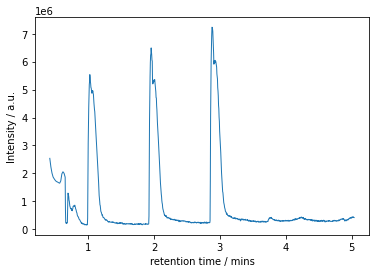

In [2]:
mega = MegaUniDec()
mega.import_mzml("C:\\Users\\cm19ljc\\Documents\\GitHub\\UniDec\\mzML\\mzML.mzML")

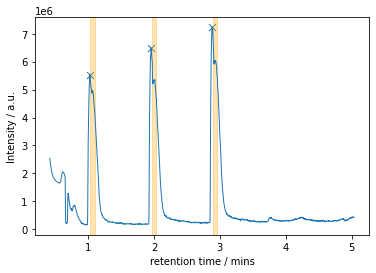

In [3]:
mega.fwhmfrac = 0.5
mega.get_peak_windows(show_tic = True)


In [4]:
mega.to_hdf5()

C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.hdf5 created


In [5]:
meta = mega.to_meta()
meta.process_data()
meta.run_unidec()


Execution Time: 0.09088449999999959
Execution Time: 2.2540376999999996


In [6]:
spectra_pks = {}
x = []
y = []
for s in meta.data.spectra:
    height = []
    mass = []
    for p in s.pks.peaks:
        height.append(p.height)
        mass.append(p.mass)
#     plt.figure()
#     plt.plot(s.massdat[:, 0], s.massdat[:, 1])
#     plt.scatter(mass, height, marker = 'x')
    
    spectra_pks[s.name] = [mass, height] # get mass and height of each peak in each spectrum
    x.append(s.massdat[:, 0])
    y.append(s.massdat[:, 1])

In [7]:
header_names = {'Well ID': {'dtype':str, 'long':True, 'short_row': False, 'short_col':False},
                'Type': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Reagent Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Reagent Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Concentration Units':{'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Time':{'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
               }
size = 6

In [8]:

for i in range(0, 3):
    x.append(np.array([]))
    y.append(np.array([]))
    
x   
x = np.array(x, dtype = object)
y = np.array(y, dtype = object)

In [54]:
platemap = pm.plate_map('long map example.csv', size = size, valid = True, header_names = header_names)


filt = platemap['Type'] != 'empty'
time = np.array(platemap[filt]['Time'], dtype = float)
wellsfull = list(platemap[filt].index)
wellsempty = list(platemap.index)[-3:]
wellsempty

['B1', 'B2', 'B3']

In [32]:
self = meta
def gen_dfs(self, data_type = "massdat"):
    """Returns 2 data frames containing x and y data of a defined datatype (e.g. massdat) for each well"""
    datax, datay = [], []
    index = []
    for s in self.data.spectra:
        temp = getattr(s, data_type)
        
        datax.append(temp[:, 0])
        datay.append(temp[:, 1])
        index.append(s.name[:-9])
    return pd.DataFrame(datax, index = index), pd.DataFrame(datay, index = index)
dfx, dfy = gen_dfs(self)

In [38]:
dfy.index = wells
dfx.index = wells
dfx

ValueError: Length mismatch: Expected axis has 3 elements, new values have 6 elements

KeyError: 'Row'

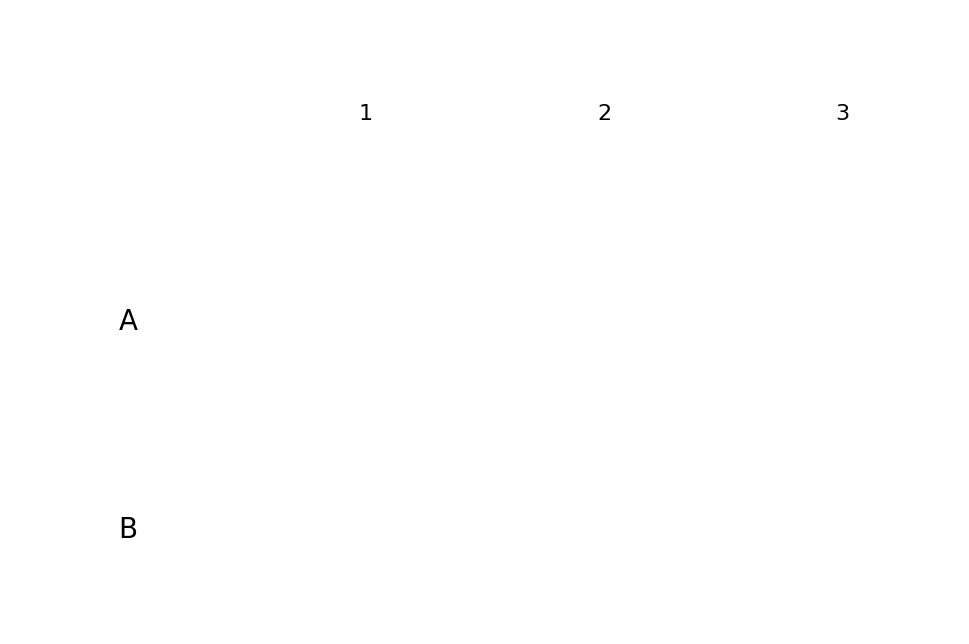

In [36]:
pm.visualise_all_series(dfx, dfy, platemap = platemap, share_y = False, size = 6)